In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Choose sample and chrom

In [5]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"



# Test pipeline manually

In [6]:
# %%time
# events_df = pl.scan_parquet(
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{denovo_chrom}.read_refinement.parquet",
# )

# events_df = diagnostics.filter_read_refinements(events_df)
# snps_df = diagnostics.extract_snps(events_df)

# snps_df = snps_df.collect(streaming=True)

In [7]:
# %%time
# #
# # Phasing coverage
# #
# hap_and_certainty_to_bedgraph = {}
# for hap in [1,2]:
#     for certainty in [0.95]: 
#         hap_and_certainty_to_bedgraph[(hap, certainty)] = \
#             str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
#                 / f"{focal_sample_id}" / f"{focal_sample_id}.{denovo_chrom}.hap{hap}.minimap2.sorted.primary_alignments.hifiasm_haplotagged_{certainty}.coverage.bedgraph")

# annotated_snps_df = diagnostics.add_phasing_coverage_annotation(
#     snps_df,
#     hap_and_certainty_to_bedgraph
# )

# #
# # TRF
# #
# annotated_snps_df = diagnostics.add_tandem_repeat_finder_annotation(
#     annotated_snps_df,
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_1/ragtag.scaffold.fasta.{denovo_chrom}.trf.dat",
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_2/ragtag.scaffold.fasta.{denovo_chrom}.trf.dat",
# )

# #
# # sdust
# #
# annotated_snps_df = diagnostics.add_sdust_annotation(
#     annotated_snps_df,
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_1/ragtag.scaffold.fasta.{denovo_chrom}.sdust.tsv",
#     f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds/{focal_sample_id}/haplotype_2/ragtag.scaffold.fasta.{denovo_chrom}.sdust.tsv",
# )


# annotated_snps_df = annotated_snps_df.collect(streaming=True)

## Some summary stats

In [8]:
# (annotated_snps_df
#     .filter(pl.col("is_high_conf_snp") == 1)
#     .select(
#         ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)).alias("is_phased_covered"),
#         ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)).alias("is_not_trf"),
#         ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)).alias("is_not_sdust"),
#         ((pl.col("qual_start1") == 93) & (pl.col("qual_start2") == 93)).alias("good_bq"),
#     )
#     .group_by(["is_phased_covered", "is_not_trf", "is_not_sdust", "good_bq"])
#     .count()
#     .sort(by="count", descending=True)
# )

In [9]:
# hap_stats_df = diagnostics.snps_to_read_stats(
#     annotated_snps_df,
#     (
#             pl.col("is_high_conf_snp") & \
#             ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)) & \
#             ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)) & \
#             ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)) & 
#             ((pl.col("qual_start1") == 93) & (pl.col("qual_start2") == 93))
#     ),
#     "frac_fits1_super_conf",    
# )

In [10]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(
#         hap_stats_df.filter(~((pl.col("frac_fits1_super_conf") == 0) | (pl.col("frac_fits1_super_conf") == 1)))
#         [:10]
#     )
    



# Analyze read

In [11]:
# focal_read = "m64094e_220715_151527/70976535/ccs"

In [12]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(annotated_snps_df
#         .drop(["is_forward1", "is_forward2", "read_length1", "read_length2", "mapq1", "mapq2"])
#         .filter(pl.col("read_name") == focal_read)
#         .filter(pl.col("op1").ne_missing(pl.col("op2")))
#         .filter(pl.col("is_high_conf_snp") == 1)
#     )
    

# SNP analysis

In [12]:
%%time
events_df = pl.scan_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.read_refinement.parquet"
)

candidates_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.parquet"
)

high_conf_snps_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet"
)

CPU times: user 2.51 s, sys: 978 ms, total: 3.49 s
Wall time: 1.53 s


## BQ

### General distribution (the first bp of all events)

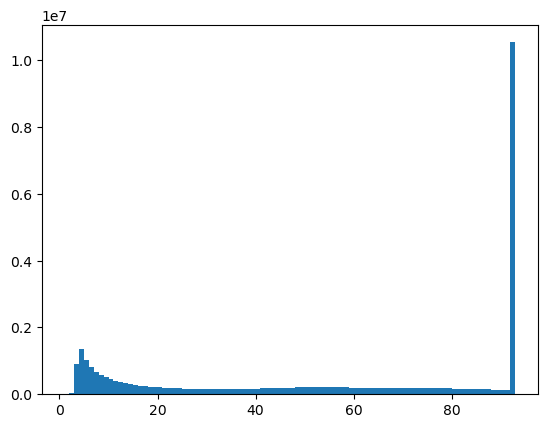

In [14]:
plt.hist(
    (events_df
        .select(pl.col("qual_start1"))
        .collect()
    ), 
    bins=np.arange(1,94)
);

### Distribution of high conf SNPs

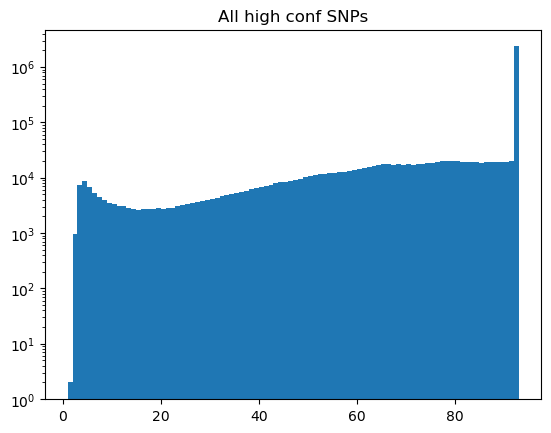

In [15]:
plt.hist(
    (high_conf_snps_df
        .select(pl.col("qual_start1"))
    ), 
    bins=np.arange(1,94),
    log=True
);
plt.title("All high conf SNPs");

In [16]:
high_conf_snps_df.shape

(3293781, 44)

In [17]:
high_conf_snps_df.head()

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,is_high_quality_event,is_high_quality_snp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,i64,i64,bool,bool
326,327,1,8,7,173527049,173527050,1,173392094,173392095,1,1,0,"""m64094e_220717…",15307,15307,true,60,"""chr2_RagTag""",64,"""T""",true,60,"""chr2_RagTag""",64,"""C""",0,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,7,11,false,false
866,867,1,8,7,173527589,173527590,1,173392634,173392635,1,3,0,"""m64094e_220717…",15307,15307,true,60,"""chr2_RagTag""",93,"""G""",true,60,"""chr2_RagTag""",93,"""T""",0,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,7,12,false,false
2603,2604,1,8,7,173529327,173529328,1,173394372,173394373,1,7,2,"""m64094e_220717…",15307,15307,true,60,"""chr2_RagTag""",93,"""T""",true,60,"""chr2_RagTag""",93,"""C""",0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,6,11,true,true
3206,3207,1,8,7,173529930,173529931,1,173394975,173394976,1,9,2,"""m64094e_220717…",15307,15307,true,60,"""chr2_RagTag""",31,"""A""",true,60,"""chr2_RagTag""",31,"""G""",0,true,false,true,true,0,0,0.0,0,0.0,0,0,false,false,7,11,false,false
3725,3726,1,8,7,173530449,173530450,1,173395494,173395495,1,11,2,"""m64094e_220717…",15307,15307,true,60,"""chr2_RagTag""",93,"""G""",true,60,"""chr2_RagTag""",93,"""A""",0,true,false,true,true,0,0,0.0,0,0.0,0,0,true,true,7,12,true,true


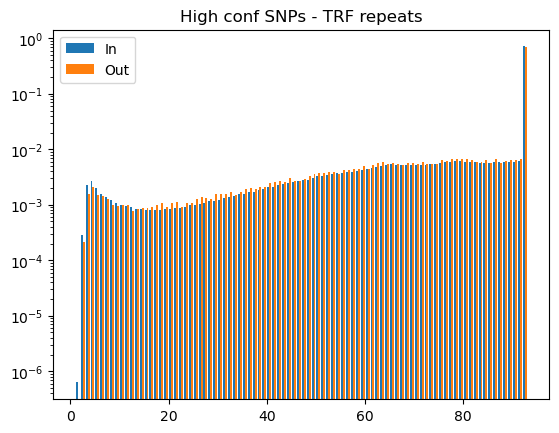

In [18]:
plt.hist(
    [
        (high_conf_snps_df
            .filter((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"],
        (high_conf_snps_df
            .filter((pl.col("trf_repeat_length_hap1") > 0) | (pl.col("trf_repeat_length_hap2") > 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"], 
    ],
    bins=np.arange(1,94),
    log=True,
    density=True,
);
plt.title("High conf SNPs - TRF repeats");
plt.legend(["In", "Out"]);

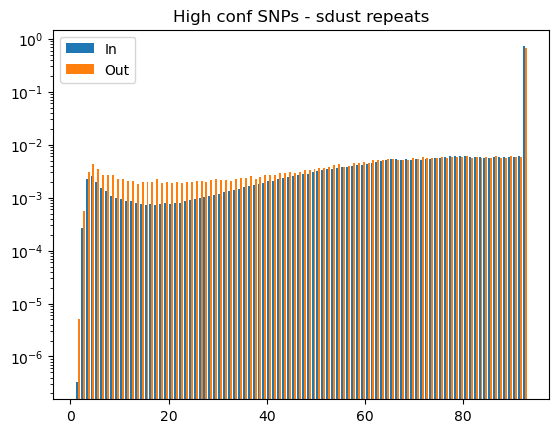

In [19]:
plt.hist(
    [
        (high_conf_snps_df
            .filter((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"],
        (high_conf_snps_df
            .filter((pl.col("sdust_repeat_length_hap1") > 0) | (pl.col("sdust_repeat_length_hap2") > 0))
            .select(pl.col("qual_start1"))
        )["qual_start1"], 
    ],
    bins=np.arange(1,94),
    log=True,
    density=True,
);
plt.title("High conf SNPs - sdust repeats");
plt.legend(["In", "Out"]);

### Look at some examples to decide a threshold (select read and SNP here, check on dashboard)

In [20]:
# plt.hist(
#     (cand_snps_df
#         .select(pl.col("qual_start1"))
#     ), 
#     bins=np.arange(1,94),
#     log=True
# );


In [21]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(cand_snps_df
#         .filter(pl.col("qual_start1") < 20)
#     )

## Calibrate BQ based on alleles

## Repeats

In [22]:
snp_stats_df = (high_conf_snps_df
    .filter(pl.col("is_high_conf_snp") == 1)
    .select(
        ((pl.col("hap1_certainty_0.95_coverage") >= 3) & (pl.col("hap2_certainty_0.95_coverage") >= 3)).alias("is_phased_covered"),
        ((pl.col("trf_repeat_length_hap1") == 0) & (pl.col("trf_repeat_length_hap2") == 0)).alias("is_not_trf"),
        ((pl.col("sdust_repeat_length_hap1") == 0) & (pl.col("sdust_repeat_length_hap2") == 0)).alias("is_not_sdust"),
        ((pl.col("qual_start1") >= 60) & (pl.col("qual_start2") >= 60)).alias("good_bq"),
    )
    .group_by(["is_phased_covered", "is_not_trf", "is_not_sdust", "good_bq"])
    .count()
    .sort(by="count", descending=True)
)

display(snp_stats_df)

is_phased_covered,is_not_trf,is_not_sdust,good_bq,count
bool,bool,bool,bool,u32
true,true,true,true,1937902
false,true,true,true,11936


In [23]:
cols = ["is_phased_covered"]
df = snp_stats_df.select(cols + ["count"]).group_by(cols).sum().sort(by="count", descending=True)
df = df.with_columns((df["count"] / df["count"].sum()).alias("frac"))
display(df)


is_phased_covered,count,frac
bool,u32,f64
true,1937902,0.993878
false,11936,0.006122


# Noisy reads

In [24]:
noise_df = (events_df
    .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
    .group_by("read_name")
    .agg(
        pl.col("length").sum(),
        pl.col("read_length1").mean(),
    )
).collect()

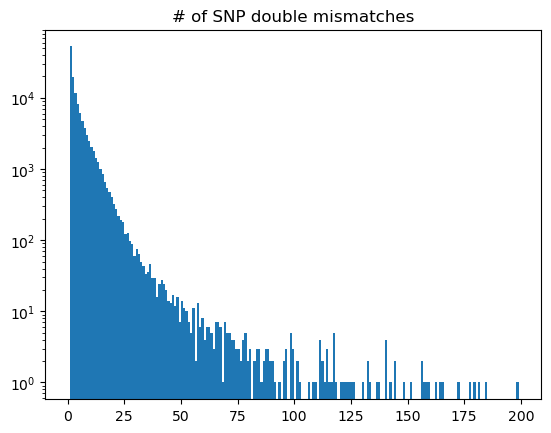

In [25]:
plt.hist(noise_df["length"], bins=np.arange(200), log=True, density=False);
plt.title("# of SNP double mismatches");

In [26]:
events_df.unique("read_name").collect().shape

(493460, 26)

In [27]:
noise_df.shape

(125341, 3)

In [28]:
(493446 - 124696) / 493446

0.7472955500703218

In [29]:
(noise_df.filter(pl.col("length") > 10)).shape

(10945, 3)

In [30]:
(493446 - 10957) / 493446

0.9777949360213681

In [31]:
(noise_df.filter(pl.col("length") > 30)).shape

(809, 3)

In [32]:
(493446 - 812) / 493446

0.9983544298666926

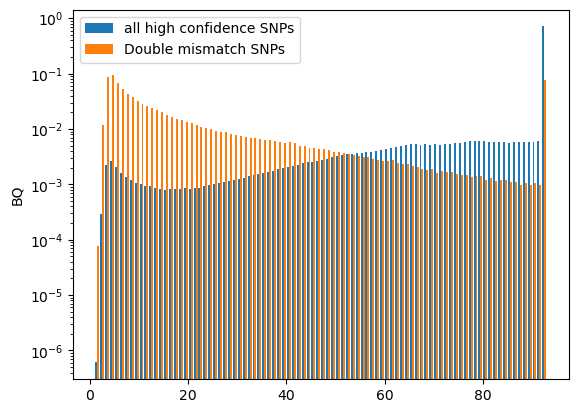

In [33]:
plt.hist(
    [
        (high_conf_snps_df.select(pl.col("qual_start1")))["qual_start1"],
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .select("qual_start1")
        ).collect()["qual_start1"]
    ], 
    bins=np.arange(1,94),
    log=True, 
    density=True,
);

plt.legend(["all high confidence SNPs", "Double mismatch SNPs"])
plt.ylabel("BQ");


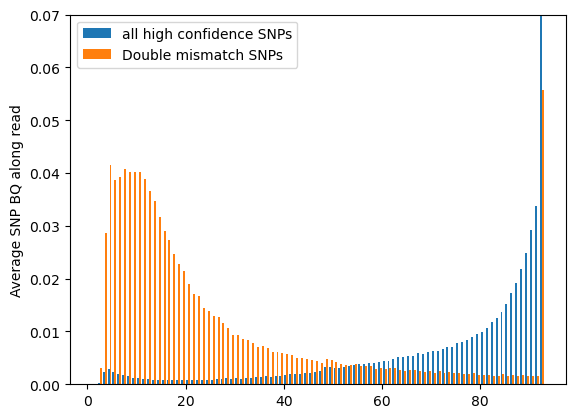

In [34]:
plt.hist(
    [
        (high_conf_snps_df
            .group_by("read_name")
            .agg(pl.col("qual_start1").mean())            
        )["qual_start1"],
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .group_by("read_name")
            .agg(pl.col("qual_start1").mean())
        ).collect()["qual_start1"]
    ], 
    bins=np.arange(1,94),
    log=False, 
    density=True,
);

plt.legend(["all high confidence SNPs", "Double mismatch SNPs"])
plt.ylabel("Average SNP BQ along read");
plt.ylim(0,0.07);

In [35]:
noise_df

read_name,length,read_length1
str,i64,f64
"""m64094e_220715…",2,9060.0
"""m64174e_220620…",1,7624.0
"""m64094e_220717…",7,13120.0
"""m64174e_220620…",4,6881.0
"""m64174e_220620…",5,26740.0
"""m64174e_220620…",1,15175.0
"""m64094e_220717…",3,7948.0
"""m64094e_220715…",6,17706.0
"""m64094e_220717…",3,23937.0


In [36]:
events_df_with_mismatches = (events_df
    .join(
        (events_df
            .filter((pl.col("op1") == 8) & (pl.col("op2") == 8) & (pl.col("length") == 1))
            .group_by("read_name")
            .agg(
                pl.col("length").sum().alias("total_mismatches"),
            )
        ),
        on="read_name",
        how="left",
    )
    .fill_null(0)
).collect()

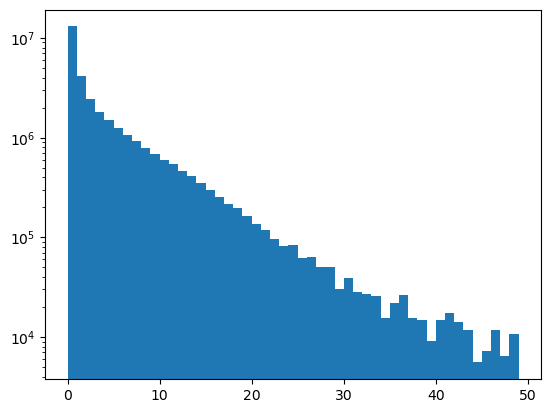

In [37]:
plt.hist(events_df_with_mismatches["total_mismatches"], bins=np.arange(0,50), log=True);

# Analyze common transitions

In [38]:
cand_snps_df = (high_conf_snps_df
    .join(candidates_df, on="read_name")
    .filter("is_high_quality_snp")
    .sort(by=["read_name", "start"])
)

nzi = np.nonzero((np.diff(cand_snps_df["fits1_more"])!=0) & (cand_snps_df["read_name"][:-1] == cand_snps_df["read_name"][1:]).to_numpy())[0]

In [39]:
common_trans_df = (
    pl.DataFrame({
        "first_hap1": cand_snps_df[nzi]["ref1_start"], 
        "second_hap1": cand_snps_df[nzi+1]["ref1_start"],
        "first_hap2": cand_snps_df[nzi]["ref2_start"], 
        "second_hap2": cand_snps_df[nzi+1]["ref2_start"],
    })
    .group_by(["first_hap1", "second_hap1", "first_hap2", "second_hap2"])
    .count()
    .sort(by="count", descending=True)
    .filter(pl.col("count") > 1)
)

common_trans_df

first_hap1,second_hap1,first_hap2,second_hap2,count
i64,i64,i64,i64,u32
130255093,130271408,130686690,130703005,2
221448905,221449976,221038225,221039296,2
97315334,97321892,97724090,97730648,2
233208301,233216667,232620237,232628586,2
58992587,59006431,58087540,58101384,2
182532538,182535131,182329127,182331721,2


In [40]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        (cand_snps_df
            .filter(pl.col("ref1_start") == 233205286)
        )["read_name"]
    )

read_name
str


# Compare COs with Sangjin's results?

## Loading files using T2T as reference

In [41]:
t2t_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13")

def t2t_load_files(sample_id):
    data_path = t2t_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"chm13.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using de-novo assembly as reference

In [42]:
denovo_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")

def denovo_load_files(sample_id):
    data_path = denovo_hapfusion_output_path / sample_id
    if not (data_path / f"{sample_id}.hapfusion.txt").exists():
        data_path = denovo_hapfusion_output_path / sample_id / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}





# What is the intersection and difference between references?

In [43]:
%%time

t2t_true_reads_dfs = {}

for sample_id in [focal_sample_id]:
    print(sample_id)

    F = t2t_load_files(sample_id)
    reads_df = F["reads"]
    
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0]
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    reads_df = reads_df[(reads_df[4] == "CO")]

    reads_df = annotate.annonate_with_mappability_mask(reads_df)
    reads_df = annotate.annotate_with_cm_ranges(reads_df) 
    reads_df = annotate.annotate_with_crossover_detection_prob(
        reads_df,
        annotate.get_all_hets(sample_id)
    )

    t2t_true_reads_dfs[sample_id] = reads_df   

PD50489e
CPU times: user 25.1 s, sys: 4.34 s, total: 29.4 s
Wall time: 1min 34s


In [44]:
%%time

denovo_true_reads_dfs = {}

for sample_id in [focal_sample_id]:
    print(sample_id)

    F = denovo_load_files(sample_id)
    reads_df = F["reads"]
    
    reads_df["read_chrom"] = reads_df[0].str.split(':').str[0].str.replace("_RagTag", "")
    reads_df["read_start_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
    reads_df["read_end_pos_0based"] = reads_df[0].str.split(':').str[1].str.split('-').str[1].astype(int)

    reads_df = reads_df[(reads_df[4] == "CO")]

    denovo_true_reads_dfs[sample_id] = reads_df   

PD50489e
CPU times: user 429 ms, sys: 40.8 ms, total: 470 ms
Wall time: 988 ms


In [45]:
denovo_true_reads_dfs[focal_sample_id].query("read_chrom == 'chr2'")

,0,1,2,3,4,5,6,7,8,9,10,11,12,read_chrom,read_start_pos_0based,read_end_pos_0based
1763,chr2_RagTag:78723144-78727622,m64174e_220620_110709/27656998/ccs,78725747,PASS,CO,0',2.9841510670730145,1443,-0000111,00000000,11111111,"chr2_RagTag:78725747_G/T,chr2_RagTag:78725758_...",.,chr2,78723144,78727622
1865,chr2_RagTag:107928358-107936285,m64174e_220620_110709/28901817/ccs,107930501,PASS,CO,0',2.9999999984964383,809,00000000111,00000000000,11111111111,"chr2_RagTag:107930501_A/G,chr2_RagTag:10793060...",.,chr2,107928358,107936285
1898,chr2_RagTag:113476698-113485455,m64174e_220620_110709/178127291/ccs,113476798,PASS,CO,0',4.999999997494064,2100,00000000000--11111,000000000000000000,111111111111111111,"chr2_RagTag:113476798_G/C,chr2_RagTag:11347683...",.,chr2,113476698,113485455
1991,chr2_RagTag:130739077-130747199,m64174e_220620_110709/2425357/ccs,130732330,PASS,CO,0',3.999999997995251,5020,1111--0000000,0000000000000,1111111111111,"chr2_RagTag:130740895_T/A,chr2_RagTag:13074211...",.,chr2,130739077,130747199
1992,chr2_RagTag:130740065-130747199,m64174e_220620_110709/45877758/ccs,130732330,PASS,CO,0',3.999999997995251,5020,1111--0000000,0000000000000,1111111111111,"chr2_RagTag:130740895_T/A,chr2_RagTag:13074211...",.,chr2,130740065,130747199
1993,chr2_RagTag:130741639-130747169,m64174e_220620_110709/109641835/ccs,130732330,PASS,CO,0',2.9999999984964383,3798,111--000000,00000000000,11111111111,"chr2_RagTag:130742117_T/C,chr2_RagTag:13074572...",.,chr2,130741639,130747169
2247,chr2_RagTag:175981895-175993330,m64174e_220620_110709/130024432/ccs,175974986,PASS,CO,0',8.67856812346725,4002,11111111100000000000000000,00000000000000000000000000,11111111111111111111111111,"chr2_RagTag:175982016_G/A,chr2_RagTag:17598307...",.,chr2,175981895,175993330


In [46]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        pl.from_pandas(t2t_true_reads_dfs[focal_sample_id]).filter(pl.col("1") == "m64094e_220717_002414/151453760/ccs")[0]["8"]
    )

8
str
"""000000100100000000000000000000000000010"""


In [47]:
t2t_true_reads_dfs[focal_sample_id].query("read_chrom == 'chr2'")[[1]]

,1
17,m64094e_220715_151527/102828298/ccs
18,m64174e_220620_110709/132777640/ccs
19,m64174e_220620_110709/85134000/ccs
20,m64174e_220620_110709/28901817/ccs
21,m64174e_220620_110709/130024432/ccs
22,m64174e_220620_110709/81462762/ccs
23,m64094e_220717_002414/151453760/ccs
24,m64094e_220717_002414/52888901/ccs


# Are transition SNPs near the ends of reads?

In [48]:
cand_snps_df = (high_conf_snps_df
    .join(candidates_df, on="read_name")
    .filter("is_high_quality_snp")
    .sort(by=["read_name", "start"])
)

nzi = np.nonzero((np.diff(cand_snps_df["fits1_more"])!=0) & (cand_snps_df["read_name"][:-1] == cand_snps_df["read_name"][1:]).to_numpy())[0]

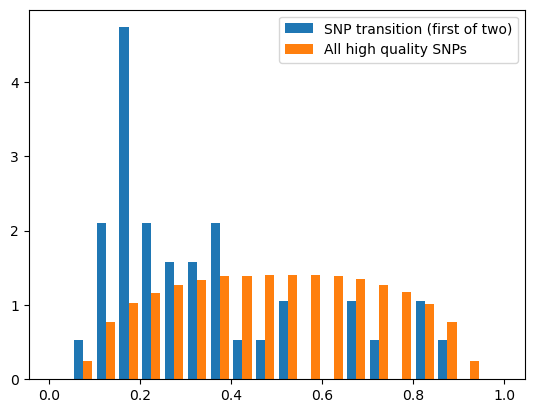

In [49]:
plt.hist(
    [
        (cand_snps_df[nzi]
            .select((pl.col("start") / pl.col("read_length1")).alias("relative_start"))
        )["relative_start"],
        (high_conf_snps_df
            .filter("is_high_quality_snp")
            .select((pl.col("start") / pl.col("read_length1")).alias("relative_start"))
        )["relative_start"],
    ],
    bins=np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (first of two)", "All high quality SNPs"]);

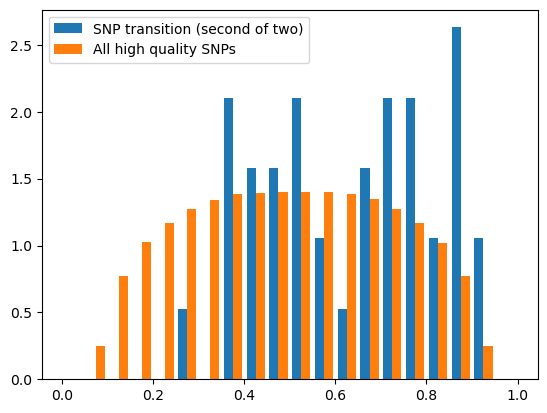

In [50]:
plt.hist(
    [
        (cand_snps_df[nzi+1]
            .select((pl.col("end") / pl.col("read_length1")).alias("relative_end"))
        )["relative_end"],
        (high_conf_snps_df
            .filter("is_high_quality_snp")
            .select((pl.col("end") / pl.col("read_length1")).alias("relative_end"))
        )["relative_end"],
    ],
    bins=np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (second of two)", "All high quality SNPs"]);

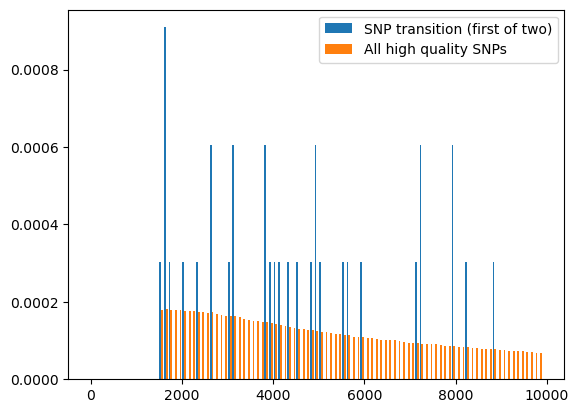

In [51]:
plt.hist(
    [
        cand_snps_df[nzi]["start"],
        high_conf_snps_df.filter("is_high_quality_snp")["start"],
    ],
    bins=np.arange(0, 10000, 100), #np.linspace(0,1,21),
    density=True,
);

plt.legend(["SNP transition (first of two)", "All high quality SNPs"]);

# Check phasing blocks?

In [52]:
backbam1 = pysam.AlignmentFile(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap1.minimap2_back_contigs.sorted.bam",
)

backbam2 = pysam.AlignmentFile(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap2.minimap2_back_contigs.sorted.bam",
)

In [53]:
contigs = set()
contig_to_cigar_stats1 = {}
contig_to_cigar_stats2 = {}

for aln1 in tqdm.tqdm(backbam1.fetch()):
    if not aln1.is_secondary or aln1.is_supplementary:
        contigs.add(aln1.query_name)
        contig_to_cigar_stats1[aln1.query_name] = aln1.query_alignment_length - aln1.get_cigar_stats()[0][0]  
        
for aln2 in tqdm.tqdm(backbam2.fetch()):
    if not aln2.is_secondary or aln2.is_supplementary:
        contigs.add(aln2.query_name)
        contig_to_cigar_stats2[aln2.query_name] = aln2.query_alignment_length - aln2.get_cigar_stats()[0][0] 


14286it [00:26, 534.12it/s] 
20344it [00:46, 434.95it/s]  


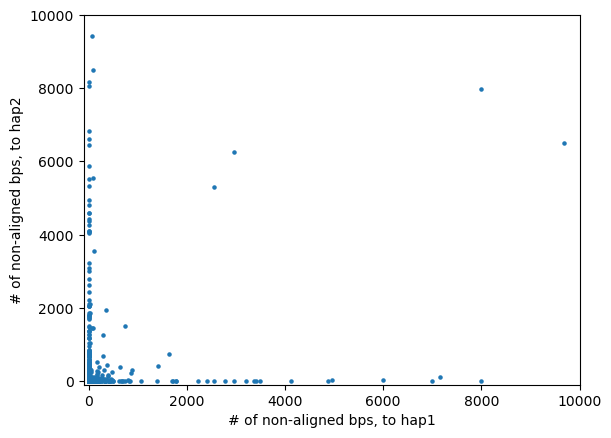

In [54]:
plt.scatter(
    [contig_to_cigar_stats1.get(contig, -1) for contig in contigs],
    [contig_to_cigar_stats2.get(contig, -1) for contig in contigs],
    s=5,
);
plt.xlabel("# of non-aligned bps, to hap1");
plt.ylabel("# of non-aligned bps, to hap2");
plt.xlim(-100,10000);
plt.ylim(-100,10000);

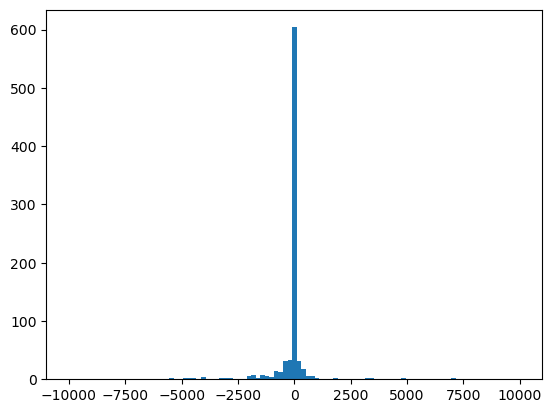

In [55]:
plt.hist(
    [contig_to_cigar_stats1.get(contig, -1)-contig_to_cigar_stats2.get(contig, -1) for contig in contigs],
    bins=np.linspace(-1e4,1e4,100),
);

In [56]:
xxx = [(1-contig_to_cigar_stats1.get(contig, -1), 1-contig_to_cigar_stats2.get(contig, -1)) for contig in contigs]


In [57]:
print(len(xxx))
print(len([x for x in xxx if x[0] == 0 or x[1] == 0]))
print(len([x for x in xxx if x[0] == 0 and x[1] == 0]))

851
70
1


In [58]:
(93)/851

0.10928319623971798

# Do reads overlap gaps in scaffolding?

In [59]:
denovo_hap1_fasta_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds") \
            / f"{focal_sample_id}" / "haplotype_1" / "ragtag.scaffold.fasta"
denovo_hap2_fasta_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/05.ragtag/03.haplotype_specific_scaffolds") \
            / f"{focal_sample_id}" / "haplotype_2" / "ragtag.scaffold.fasta"

denovo_hap1_alignment_bam_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / f"{focal_sample_id}.hap1.minimap2.sorted.primary_alignments.bam"
denovo_hap2_alignment_bam_file = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / f"{focal_sample_id}.hap2.minimap2.sorted.primary_alignments.bam"

denovo_hap1_bam = pysam.AlignmentFile(denovo_hap1_alignment_bam_file)
denovo_hap2_bam = pysam.AlignmentFile(denovo_hap2_alignment_bam_file)


In [60]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"

from Bio import SeqIO
for record1 in SeqIO.parse(denovo_hap1_fasta_file, format="fasta"):
    if denovo_chrom in record1.id:
        break
        
for record2 in SeqIO.parse(denovo_hap2_fasta_file, format="fasta"):
    if denovo_chrom in record2.id:
        break        

In [61]:
test_read = "m64094e_220715_151527/83298762/ccs"

In [62]:
%%time
for denovo_hap1_read_aln in denovo_hap1_bam.fetch(denovo_chrom, multiple_iterators=True):
    if denovo_hap1_read_aln.query_name == test_read:
        print("found it")
        break

for denovo_hap2_read_aln in denovo_hap2_bam.fetch(denovo_chrom, multiple_iterators=True):
    if denovo_hap2_read_aln.query_name == test_read:
        print("found it")
        break
        

found it
found it
CPU times: user 18.7 s, sys: 1.13 s, total: 19.8 s
Wall time: 43.4 s


In [63]:
'N' in record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end]

False

In [64]:
denovo_hap1_read_aln.reference_length

10468

In [65]:
record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end].find('N')

-1

In [66]:
'N' in record2.seq[denovo_hap2_read_aln.reference_start:denovo_hap2_read_aln.reference_end]

False

In [67]:
for denovo_hap1_read_aln in denovo_hap1_bam.fetch(denovo_chrom, multiple_iterators=True):
    ref = record1.seq[denovo_hap1_read_aln.reference_start:denovo_hap1_read_aln.reference_end]
    if 'N' in ref:
        print("found something", denovo_hap1_read_aln.query_name, ref.find('N'), len(ref))
        break

found something m64094e_220717_002414/102762061/ccs 18356 21085


# Classify SNPs - test code

In [68]:
%%time
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]


all_res = []

def dome(focal_sample_id, denovo_chrom):
    candidates_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.parquet"
    )

    snps_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet"
    )
    
    cov1_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.hap1.coverage_refinement.parquet"
    )

    cov2_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.hap2.coverage_refinement.parquet"
    )
    
    res_df = diagnostics.classify_all_reads(
        snps_df,
        candidates_df,
        cov1_df,
        cov2_df,
    )
    
    res_df = res_df.with_columns(pl.lit(denovo_chrom).alias("chrom"), pl.lit(focal_sample_id).alias("sample_id"))

    # res_df = diagnostics.classify_read(snps_df
    #     .filter(pl.col("read_name") == "m64174e_220620_110709/24904780/ccs")
    #     .join(cov1_df, on=["read_name", "start", "end"], how="outer")
    #     .join(cov2_df, on=["read_name", "start", "end"], how="outer")
    # )  
    
    
    return res_df
    
all_res_df = dome("PD50489e", "chr2_RagTag")
# all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
#     joblib.delayed(dome)(focal_sample_id, chrom + "_RagTag") \
#         for chrom in ["chr2"] #aut_chrom_names 
#         for focal_sample_id in ["PD50489e"] #sample_ids
# )
        
# all_res_df = pl.concat(all_res)

CPU times: user 2.77 s, sys: 1.58 s, total: 4.35 s
Wall time: 5.18 s


In [69]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(all_res_df)

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,has_common_transition,chrom,sample_id
str,i64,i64,list[i64],list[i64],str,i64,i64,bool,str,str
"""m64174e_220620_110709/114033682/ccs""",19373,1,[0],"[4940, 14173, 16968]","""ambiguous""",1,4,false,"""chr2_RagTag""","""PD50489e"""
"""m64094e_220715_151527/153551949/ccs""",16692,1,[0],"[2661, 10723]","""ambiguous""",5,4,false,"""chr2_RagTag""","""PD50489e"""
"""m64094e_220717_002414/70780745/ccs""",13226,1,[2],"[2130, 2343, … 11510]","""ambiguous""",2,4,false,"""chr2_RagTag""","""PD50489e"""
"""m64174e_220620_110709/26609769/ccs""",23910,1,[3],"[1891, 2970, … 21030]","""CO""",1,3,false,"""chr2_RagTag""","""PD50489e"""
"""m64174e_220620_110709/119145114/ccs""",24195,1,[0],"[5677, 21990]","""ambiguous""",0,1,true,"""chr2_RagTag""","""PD50489e"""
"""m64174e_220620_110709/130024432/ccs""",11481,1,[0],"[2040, 5947, … 9613]","""ambiguous""",17,8,false,"""chr2_RagTag""","""PD50489e"""
"""m64094e_220715_151527/21168853/ccs""",26205,1,[0],"[3025, 20448]","""ambiguous""",3,3,false,"""chr2_RagTag""","""PD50489e"""
"""m64094e_220715_151527/26741085/ccs""",25647,1,[5],"[2151, 2632, … 23645]","""CO""",8,3,false,"""chr2_RagTag""","""PD50489e"""
"""m64094e_220717_002414/148310378/ccs""",18537,1,[4],"[3167, 4301, … 16391]","""CO""",11,7,false,"""chr2_RagTag""","""PD50489e"""


In [70]:
all_res_df["class"].value_counts()

class,counts
str,u32
"""ambiguous""",20
"""GC""",2
"""CO""",14


In [71]:
all_res_df.filter(~pl.col("has_common_transition"))["class"].value_counts()

class,counts
str,u32
"""CO""",10
"""ambiguous""",13
"""GC""",1


In [72]:
all_res_df.filter(~pl.col("has_common_transition") & (pl.col("min_coverage_1") >= 3) & (pl.col("min_coverage_2") >= 3))["class"].value_counts()


ColumnNotFoundError: unable to find column "min_coverage_1"; valid columns: ["read_name", "read_length", "n_transitions", "idx_transitions", "snp_positions_on_read", "class", "min_coverage_between_transitions_hap1", "min_coverage_between_transitions_hap2", "has_common_transition", "chrom", "sample_id"]

Error originated just after this operation:
DF ["read_name", "read_length", "n_transitions", "idx_transitions"]; PROJECT */11 COLUMNS; SELECTION: "None"

In [ ]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    #display(res_df)
    #display(all_res_df.filter(~pl.col("has_common_transition")))
    display(all_res_df.filter(pl.col("has_common_transition") & (pl.col("min_coverage_1") >= 3) & (pl.col("min_coverage_2") >= 3)))
    #display(res_df.filter(pl.col("read_name") == "m64174e_220620_110709/58458841/ccs"))

# NAHR?

In [ ]:
alns = {}
for aln in pysam.AlignmentFile("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap1.minimap2.sorted.multiple_alignments.bam"):
    alns[aln.query_name] = alns.get(aln.query_name, []) + [aln]


In [ ]:
chrcounts = pd.Series([(v[0].reference_name, v[1].reference_name) for v in alns.values() if len(v) == 2 and v[0].query_length > 5000]).value_counts().to_dict()

M = np.array([[chrcounts.get((ci+"_RagTag", cj+"_RagTag"), 0) for ci in aut_chrom_names] for cj in aut_chrom_names])
A = M.T.copy()
np.fill_diagonal(A, 0)
M += A

sns.heatmap(
    M,
    xticklabels=aut_chrom_names,
    yticklabels=aut_chrom_names,
)

plt.title("Pairs of chroms, for reads of length >5kbp");

In [ ]:
plt.hist([v[0].query_length for v in alns.values()], bins=np.linspace(0,10000,100));
plt.xlabel("length of chimeric reads");

In [ ]:
plt.hist(
    [np.abs(v[0].reference_start - v[1].reference_start) for v in alns.values() if len(v) == 2 and v[0].reference_name == v[1].reference_name],
    bins=100,
    log=True,
);

plt.xlabel("Gap between alignments on the same chrom");

In [ ]:
plt.hist(
    [np.abs(v[0].reference_start - v[1].reference_start) for v in alns.values() if len(v) == 2 and v[0].reference_name == v[1].reference_name],
    bins=np.linspace(0, 1e5, 100),
    log=False,
);

plt.xlabel("Gap between alignments on the same chrom");

In [ ]:
chrcounts = pd.Series([(v[0].reference_name, v[1].reference_name) for v in alns.values() \
    if len(v) == 2 and v[0].query_length > 5000 and ((v[0].reference_name != v[1].reference_name) or (np.abs(v[0].reference_start - v[1].reference_start) > 1e5))
] ).value_counts().to_dict()

M = np.array([[chrcounts.get((ci+"_RagTag", cj+"_RagTag"), 0) for ci in aut_chrom_names] for cj in aut_chrom_names])
A = M.T.copy()
np.fill_diagonal(A, 0)
M += A

sns.heatmap(
    M,
    xticklabels=aut_chrom_names,
    yticklabels=aut_chrom_names,
)

plt.title("Pairs of chroms, for reads of length >5kbp, same-chr gap > 1e5bp");

In [ ]:
plt.hist(
    np.array([np.abs(v[0].reference_start - v[1].reference_start) for v in alns.values() \
              if len(v) == 2 and v[0].reference_name == v[1].reference_name and v[0].query_length > 5000]),
    bins=np.linspace(1e5, 1e7, 100),
    log=True,
);

plt.xlabel("Gap between alignments on the same chrom");

In [ ]:
seg_df = pd.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/PD50489e/PD50489e.hap1.minimap2.sorted.multiple_alignments.read_names.T2T_mapped.bed",
    delim_whitespace=True,
    header=None,
    names=[
        "reference_name", "reference_start_pos_1based", "reference_end_pos_1based", "read_name", "mapq", "strand", 
        6,7,8,9,10,11,
        "segdup_chrom", "segdup_chrom_start_pos_1based", "segdup_chrom_end_pos_1based", "other_dup", 
        16, 17, 18, 19, 20, 
        "overlap",
    ],
)

In [ ]:
seg_df

In [ ]:
import functools
import operator



In [ ]:
overlaps = (seg_df
    .loc[lambda df: (df["mapq"] >= 60)]
    .groupby("read_name")
    .agg({"overlap": "max"})
    ["overlap"]
)

In [ ]:
(overlaps > 0).mean()

In [ ]:
plt.hist(overlaps[(overlaps > 0)], bins=50);

In [ ]:
v = list(alns.values())[0]

# Debug coverage

In [ ]:
%%time
events_df = pl.scan_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.read_refinement.parquet"
)

candidates_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.parquet"
)

high_conf_snps_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet"
)

In [ ]:
cov1_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.hap1.coverage_refinement.parquet"
)

cov2_df = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.candidate_reads.hap2.coverage_refinement.parquet"
)

In [ ]:
test_read = "m64094e_220715_151527/153551949/ccs"
xdf1 = cov1_df.filter(pl.col("read_name") == test_read).filter(pl.col("min_coverage_hap1").is_not_null())
xdf2 = cov2_df.filter(pl.col("read_name") == test_read).filter(pl.col("min_coverage_hap2").is_not_null())
plt.step(
    xdf1["start"],
    xdf1["min_coverage_hap1"],
    where="post",
)
plt.step(
    xdf2["start"],
    xdf2["min_coverage_hap2"],
    where="post",
)
#plt.xlim(0,200);

In [ ]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(
        
    )

In [ ]:
# with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
#     display(
#         events_df.filter(pl.col("read_name") == "m64094e_220715_151527/21168853/ccs").collect()
#     )

In [ ]:
"m64094e_220715_151527/21168853/ccs", 15764

In [ ]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(cov_df
        .filter(pl.col("min_coverage_hap1").is_not_null())
        .group_by("read_name")
        .min()
    )

# Check classified events

In [ ]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [ ]:
events_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
    / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_0.95.snps.parquet")

In [ ]:
sample_of_first_snps = (events_df
    .join(
        (events_df
            .filter("is_high_quality_snp")
            .group_by("read_name").count()
            .filter(pl.col("count") >= 7)
            .select("read_name")
        ),
        on="read_name",
    )
    .sort(["read_name", "start"])
    .group_by("read_name").head()
    .select(pl.col("start").alias("dist_from_end"))
).collect()

In [ ]:
xx = (cls_df
    .filter(pl.col("class") == "ambiguous")
    .filter((pl.col("idx_transitions").list.get(0) == 0) & (pl.col("snp_positions_on_read").list.len() >= 7))
    .select(pl.col("snp_positions_on_read").list.get(0).alias("dist_from_end"))
)

plt.hist(
    [sample_of_first_snps["dist_from_end"], xx["dist_from_end"]], 
    bins=np.linspace(0,20000,200), 
    density=True
);
plt.xlim(0, 7000);
plt.xlabel("First SNP position")
plt.legend(["In all reads with >=7 SNPs", "Transition at first SNP, at reads with >=7 SNPs"]);

In [ ]:
yy = (cls_df
    .filter(pl.col("class") == "ambiguous")
    .filter((pl.col("idx_transitions").list.get(-1) == (pl.col("snp_positions_on_read").list.len()-2)) & (pl.col("snp_positions_on_read").list.len() >= 7))
    .select((pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)).alias("dist_from_end"))
)

plt.hist(yy, bins=np.linspace(0,7000,100));
plt.xlabel("Distance of last SNP to read end")

In [ ]:
plt.hist(pl.concat([xx, yy]), bins=np.linspace(0,7000,100));
plt.xlabel("Both")

## How much would we lose shaving these off?

### Before read trimming

In [ ]:
(cls_df.filter(~pl.col("has_common_transition")))["class"].value_counts()

### After read trimming

In [ ]:
# (cls_df
#     .filter(~pl.col("has_common_transition"))
#     .filter(
#         (pl.col("n_transitions") > 1) |
#         (~pl.col("idx_transitions").list.contains(0) | (pl.col("snp_positions_on_read").list.get(0) > 2000)) | 
#         (~pl.col("idx_transitions").list.contains(pl.col("snp_positions_on_read").list.len()-2) |
#           ((pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) > 2000))
#     )
# )["class"].value_counts()

### After coverage

In [ ]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=50):
    display(cls_df
        .filter(~pl.col("has_common_transition"))
        .filter(
            (pl.col("min_coverage_between_transitions_hap1") >= 3) &
            (pl.col("min_coverage_between_transitions_hap2") >= 3)
        )
        .filter(pl.col("class") == "CNCO")
        #.filter(pl.col("sample_id") == "PD50489e")
        #.filter(pl.col("chrom") == "chr2_RagTag")
        # .filter(
        #     (pl.col("n_transitions") > 1) |        
        #     (~pl.col("idx_transitions").list.contains(0) | (pl.col("snp_positions_on_read").list.get(0) > 2000)) | 
        #     (~pl.col("idx_transitions").list.contains(pl.col("snp_positions_on_read").list.len()-2) |
        #       ((pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) > 2000))
        # )
    )#["class"].value_counts()

In [ ]:
xs = np.arange(1, 20)
ys = []
for x in xs:
    vc = (cls_df
        .filter(~pl.col("has_common_transition"))
        .filter(
            (pl.col("min_coverage_between_transitions_hap1") >= 3) &
            (pl.col("min_coverage_between_transitions_hap2") >= 3)
        )
        .filter(pl.col("snp_positions_on_read").list.len() >= x)
    )["class"].value_counts().rows_by_key(key=["class"], named=True, unique=True)
    ys.append([vc["CO"]["counts"], vc["ambiguous"]["counts"]])

In [ ]:
plt.plot(xs, np.array(ys).T[0])
plt.plot(xs, np.array(ys).T[1])
plt.legend(["CO", "amb"]);